In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
from scipy.optimize import curve_fit

sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer
from scalar_features import ScalarFeaturizer
from read_halos import SimulationReader
from fit import Fitter
import plotter

%load_ext autoreload
%autoreload 2

In [2]:
# sim / halo info
base_dir = '/scratch/ksf293/equivariant-cosmology/data'
snap_num_str = '099' # z = 0
sim_name = 'TNG100-1'
sim_name_dark = 'TNG100-1-Dark'
# sim_name = 'TNG50-4'
# sim_name_dark = 'TNG50-4-Dark'
halo_dir = f'../data/halos/halos_{sim_name}'
halo_tag = '_nstarpartmin1'
fn_dark_halo_arr = f'{halo_dir}/halos_{sim_name}{halo_tag}.npy'
mass_multiplier = 1e10

In [3]:
# geo info
geo_dir = f'../data/geometric_features/geometric_features_{sim_name}'
geo_tag = ''
fn_geo_features = f'{geo_dir}/geometric_features{halo_tag}{geo_tag}.npy'

In [4]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(fn_geo_features)

In [5]:
sim_reader = SimulationReader(base_dir, sim_name, sim_name_dark, snap_num_str)
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()
sim_reader.add_catalog_property_to_halos('mass_hydro_subhalo_star')
sim_reader.add_catalog_property_to_halos('m200m')

In [6]:
m_stellar = np.array([dark_halo.catalog_properties['mass_hydro_subhalo_star'] for dark_halo in sim_reader.dark_halo_arr])
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])

In [7]:
def fit_and_plot(fitter, m_halo, rms_x=True, log_x=False, log_y=False, y_lim=None):
    fitter.split_train_test()
    print("scale fit")
    fitter.scale_and_fit(rms_x=rms_x, log_x=log_x, log_y=log_y)
    print("pred test")
    fitter.predict_test()

    # Extract arrays and plot
    y_true = fitter.y_scalar_test*mass_multiplier
    y_pred = fitter.y_scalar_pred*mass_multiplier
    msfe_test = np.mean(((y_pred - y_true)/y_true)**2)
    
    print("pred train")
    y_train_pred = fitter.predict(fitter.x_scalar_train, fitter.y_val_current_train)*mass_multiplier
    y_train_true = fitter.y_scalar_train*mass_multiplier
    chi2_train = fitter.chi2

    plotter.plot_pred_vs_true(y_true, y_pred, y_train_true, y_train_pred, 
                              fitter, msfe_test, chi2_train, mass_multiplier, y_lim=y_lim)

    mass = m_halo[fitter.idx_test]
    mass_train = m_halo[fitter.idx_train]

    plotter.plot_pred_vs_mass(mass, y_true, y_pred, mass_train, y_train_true, y_train_pred, 
                  fitter, msfe_test, chi2_train, mass_multiplier, y_lim=y_lim)

### Single bin, no rescaling

In [8]:
m_order_max = 2
n_groups_rebin = np.atleast_2d(np.arange(8))
eigenvalues_not_trace = False

uncertainty_floor = 2e8/mass_multiplier
uncertainties_01floor = np.sqrt((0.1*m_stellar)**2 + uncertainty_floor**2)

y_val_current_const = np.ones(len(m_stellar))

In [9]:
scalar_featurizer_1bin = ScalarFeaturizer(geo_featurizer.geo_feature_arr)
scalar_featurizer_1bin.featurize(m_order_max, n_groups_rebin=n_groups_rebin,
                        eigenvalues_not_trace=eigenvalues_not_trace)

Rebinning
Rebinned to 1 bins!


scale fit
pred test
pred train


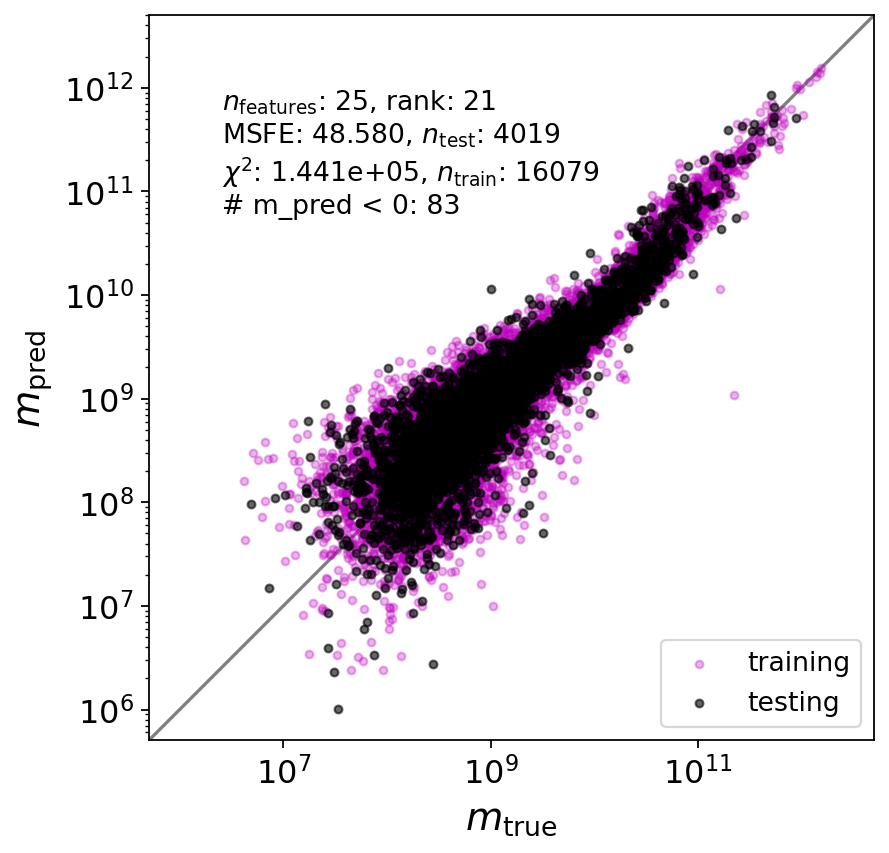

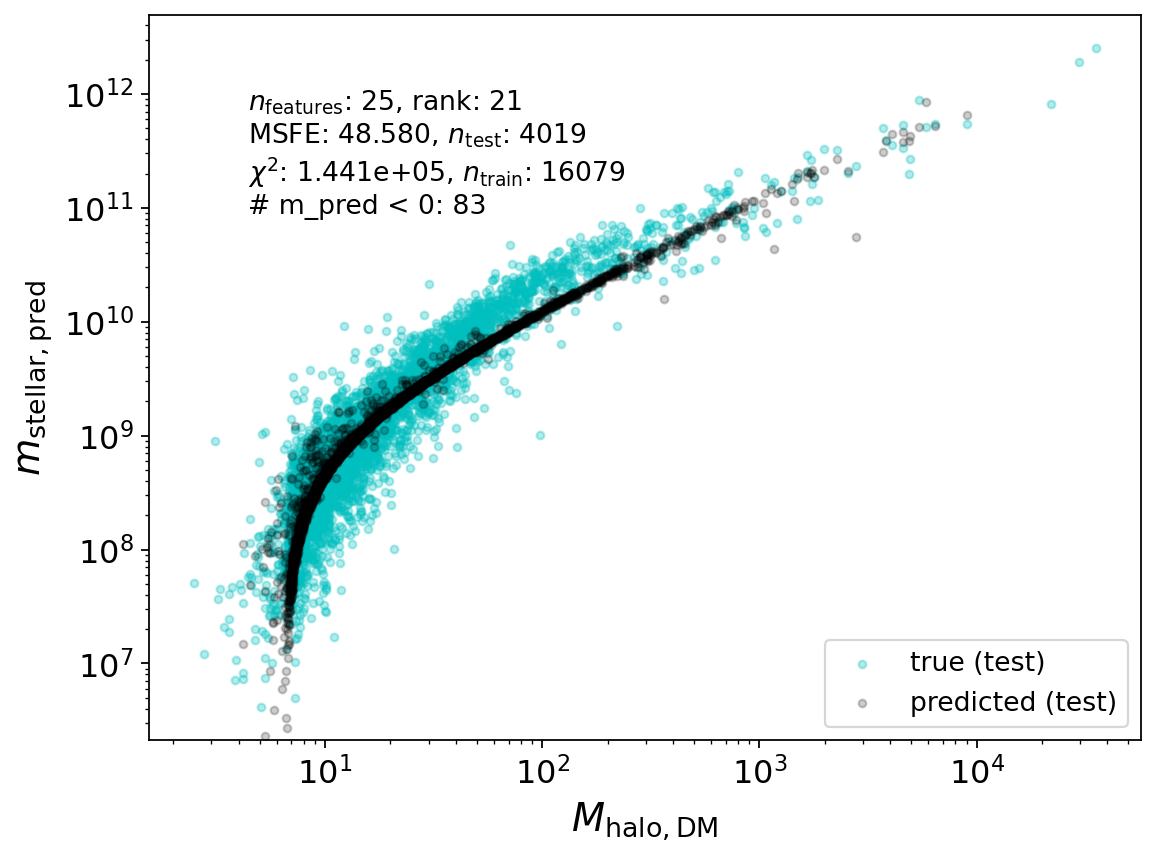

In [10]:
fitter = Fitter(scalar_featurizer_1bin.scalar_features, m_stellar, 
                    y_val_current_const, uncertainties=uncertainties_01floor)
fit_and_plot(fitter, m_200m)

### Two bins (inner/outer) eigenvalues, no rescaling

In [11]:
m_order_max = 2
n_groups_rebin = [[0,1,2], [3,4,5,6,7]]
eigenvalues_not_trace = True

In [12]:
scalar_featurizer_2bins = ScalarFeaturizer(geo_featurizer.geo_feature_arr)
scalar_featurizer_2bins.featurize(m_order_max, n_groups_rebin=n_groups_rebin,
                        eigenvalues_not_trace=eigenvalues_not_trace)

Rebinning
Rebinned to 2 bins!


scale fit
pred test
pred train


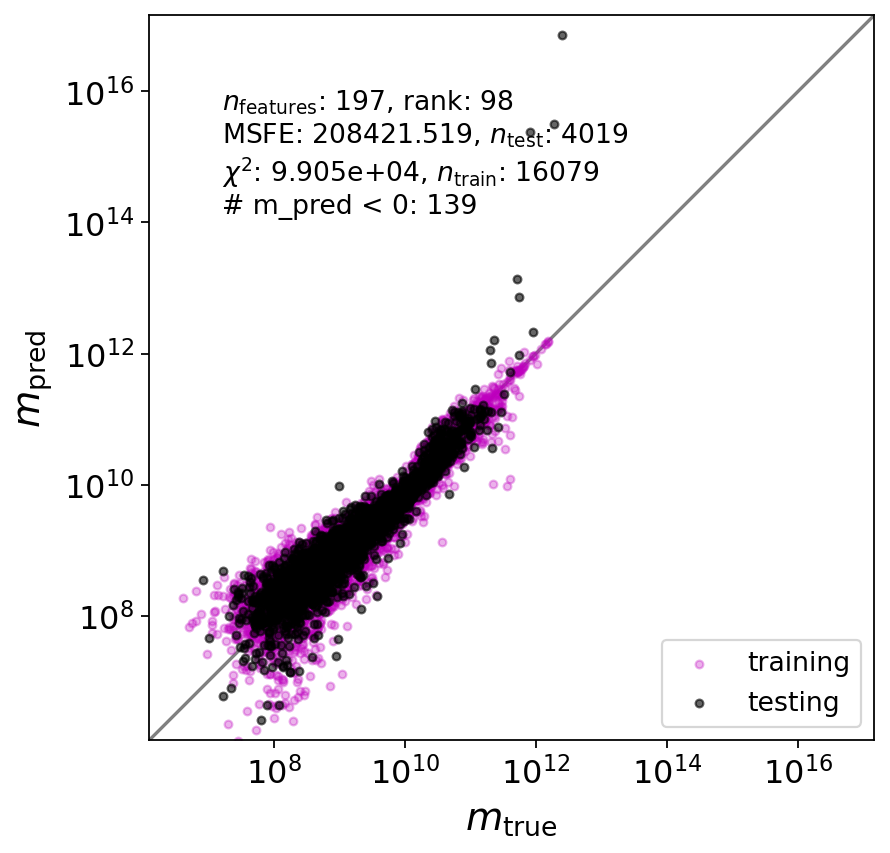

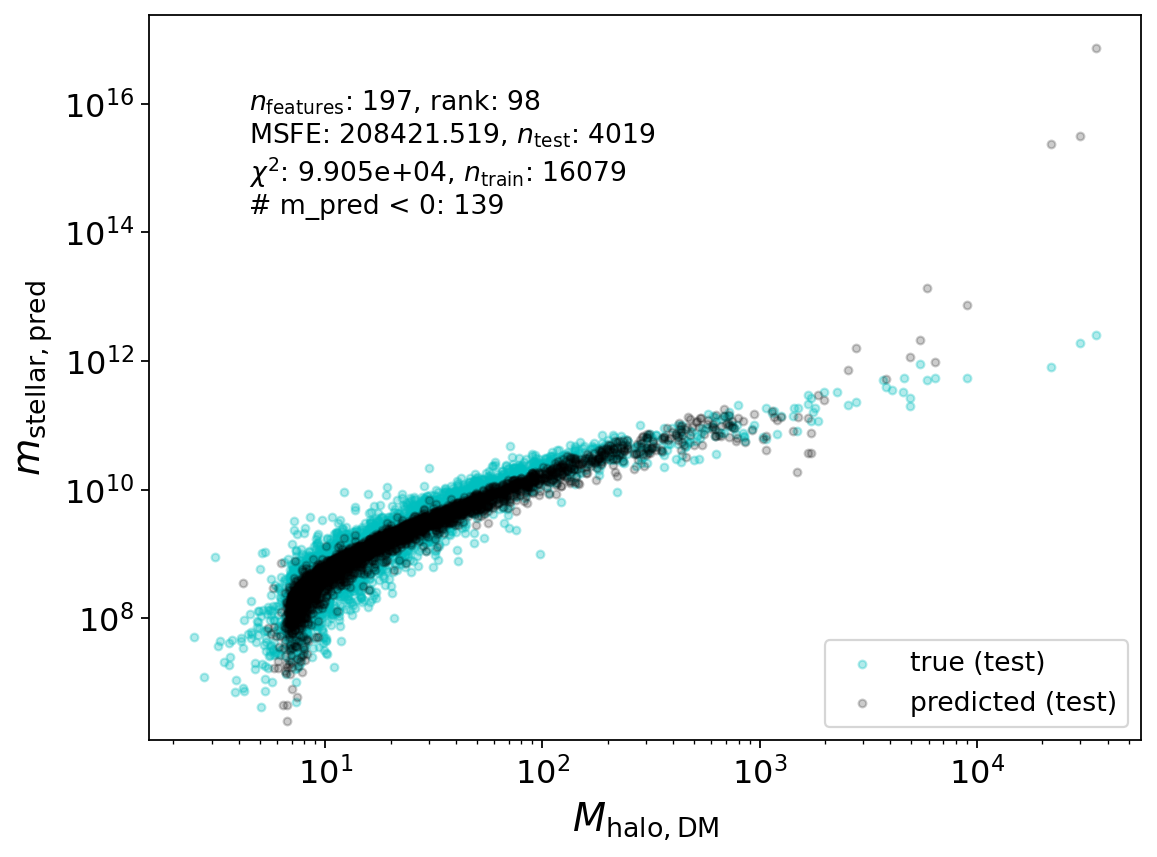

In [13]:
fitter = Fitter(scalar_featurizer_2bins.scalar_features, m_stellar, 
                    y_val_current_const, uncertainties=uncertainties_01floor)
fit_and_plot(fitter, m_200m)

### Two bins (inner/outer) eigenvalues, with rescaling

In [14]:
scalar_featurizer_rescaled = ScalarFeaturizer(geo_featurizer.geo_feature_arr)
scalar_featurizer_rescaled.compute_MXV_from_features()
scalar_featurizer_rescaled.rescale_geometric_features(scalar_featurizer_rescaled.M_tot, 
                                             scalar_featurizer_rescaled.X_rms, 
                                             scalar_featurizer_rescaled.V_rms)
scalar_featurizer_rescaled.featurize(m_order_max, n_groups_rebin=n_groups_rebin,
                        eigenvalues_not_trace=eigenvalues_not_trace)

Rebinning
Rebinned to 2 bins!


scale fit
pred test
pred train


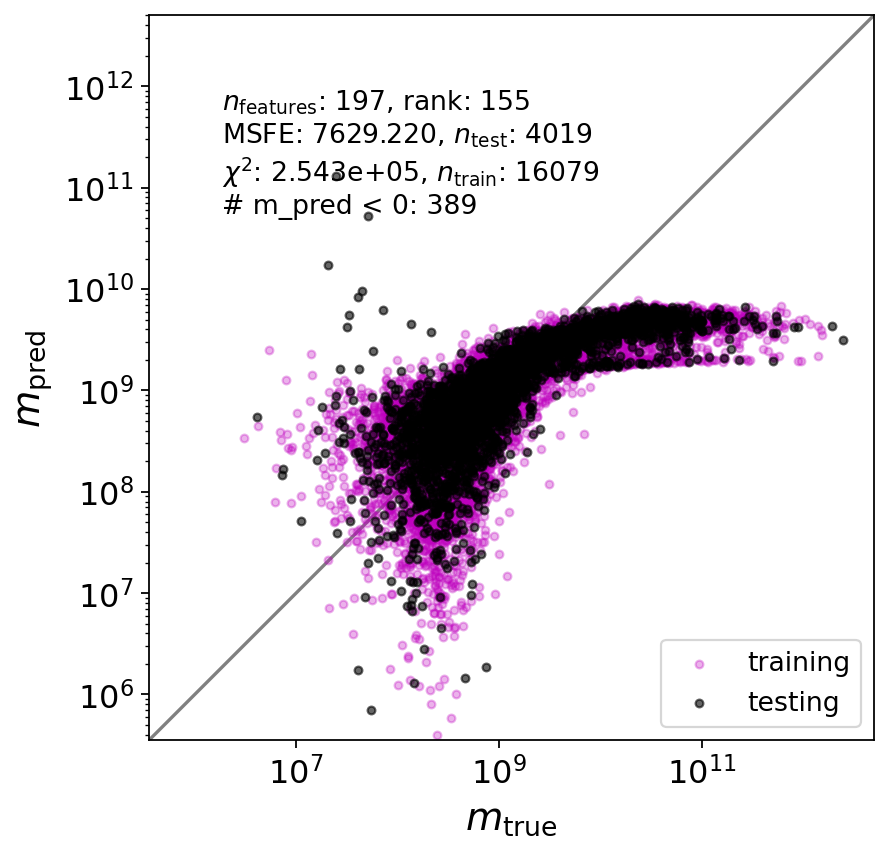

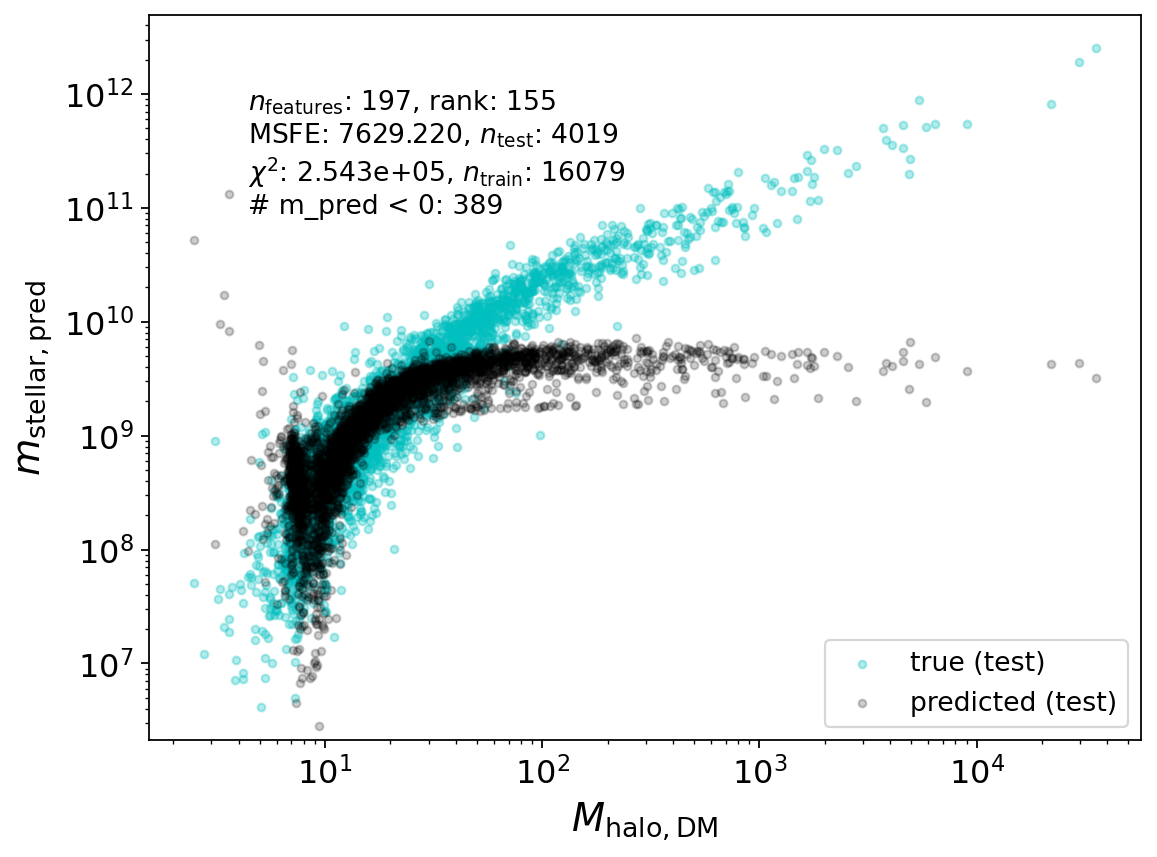

In [15]:
fitter = Fitter(scalar_featurizer_rescaled.scalar_features, m_stellar, 
                    y_val_current_const, uncertainties=uncertainties_01floor)
fit_and_plot(fitter, m_200m)

### Include fit power law and improved uncertainties

In [16]:
logmstellar_bins = np.linspace(8.5, 11, 6)
logmstellar_bins = np.array([5] + list(logmstellar_bins) + [13])
# added estimates on either end
stdev_dict = {'TNG50-4': np.array([0.4, 0.28, 0.23, 0.12, 0.05, 0.04, 0.04]), # epsilon=4, similar to tng50-4
              'TNG100-1': np.array([0.15, 0.08, 0.06, 0.04, 0.03, 0.04, 0.04]), # epsilon=1, similar to tng100-1
             }

logyscalar = np.log10(m_stellar*mass_multiplier)
idxs_mbins = np.digitize(logyscalar, logmstellar_bins)

stdevs = stdev_dict[sim_name][idxs_mbins-1]
uncertainties_genel2019 = stdevs * m_stellar * np.log(10.0)
# hack to deal with 0-stellar-mass objects
uncertainties_genel2019[uncertainties_genel2019==0] = stdev_dict[sim_name][0] * 10**logmstellar_bins[0]/mass_multiplier

In [17]:
def broken_power_law(M200, N=0.01, M1=1e12/mass_multiplier, beta=1.5, gamma=0.4):
    return M200*2*N/((M200/M1)**(-beta) + (M200/M1)**gamma)

In [18]:
p0 = [0.01, 1e12/mass_multiplier, 1.5, 0.4]
bounds = [[0]*len(p0), [np.inf]*len(p0)]
popt, _ = curve_fit(broken_power_law, m_200m, m_stellar, sigma=uncertainties_genel2019, 
                    bounds=bounds, p0=p0)
y_val_current_powerlaw_fit = broken_power_law(m_200m, *popt)

Text(0, 0.5, 'm_stellar')

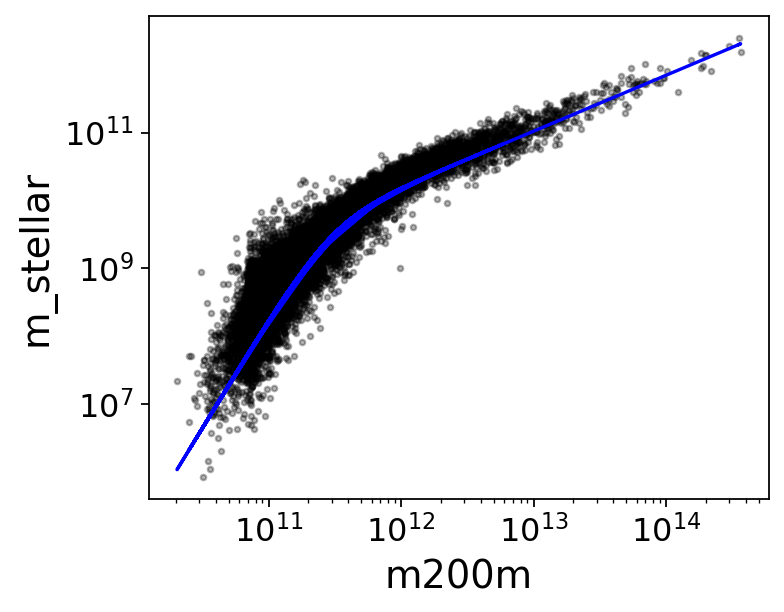

In [19]:
plt.figure(figsize=(5,4))
plt.scatter(m_200m*mass_multiplier, m_stellar*mass_multiplier, s=6, c='k', alpha=0.3)
plt.plot(m_200m*mass_multiplier, y_val_current_powerlaw_fit*mass_multiplier, color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m200m')
plt.ylabel('m_stellar')

scale fit
pred test
pred train


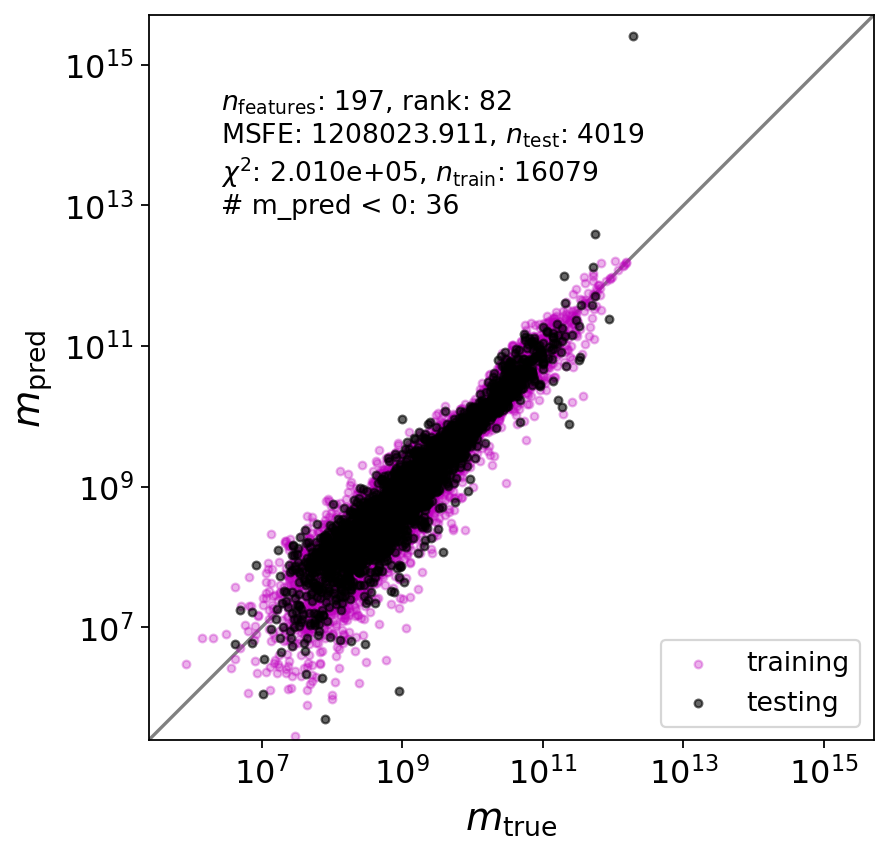

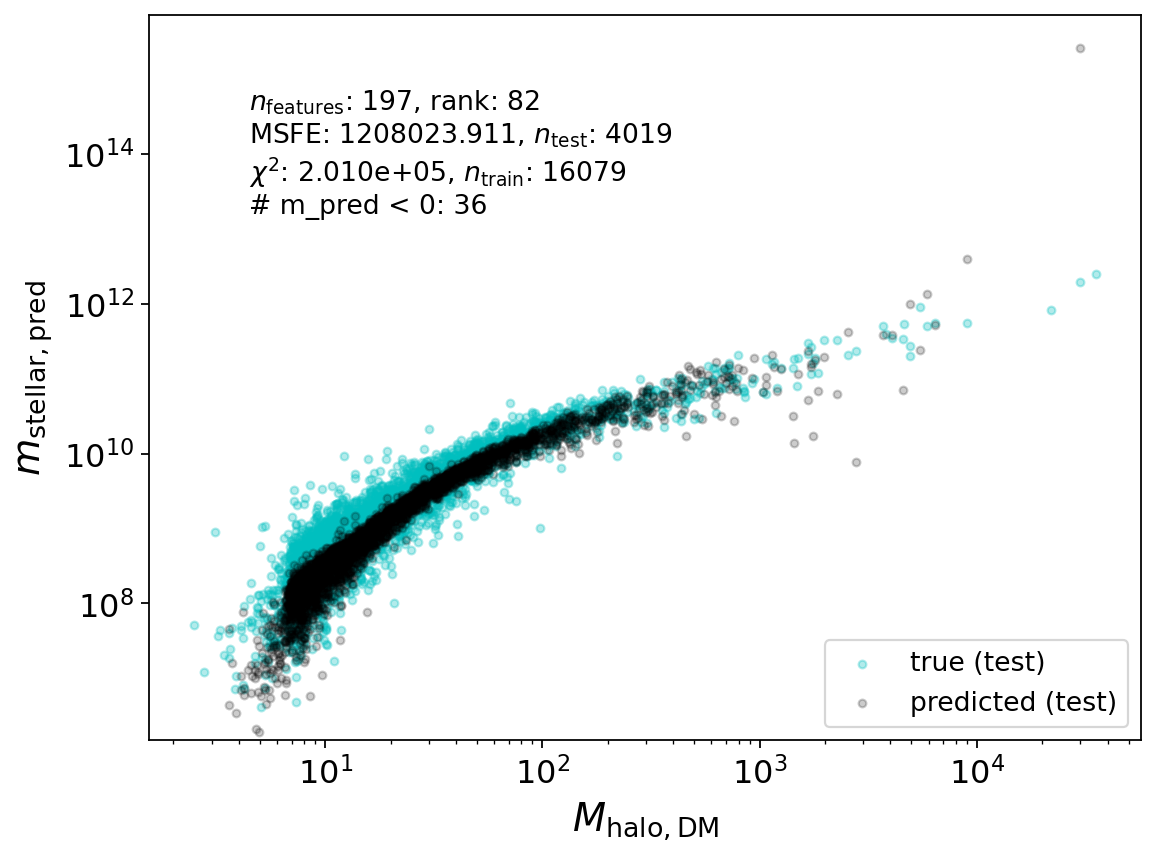

In [20]:
fitter = Fitter(scalar_featurizer_2bins.scalar_features, m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019)
fit_and_plot(fitter, m_200m)

### Log y values: input powerlaw, uncertainties; output m_stellar

Single r bin, no eigenvalues:

scale fit
2.2539603330600606
pred test
41.259365352009084
pred train
2.2539603330600606


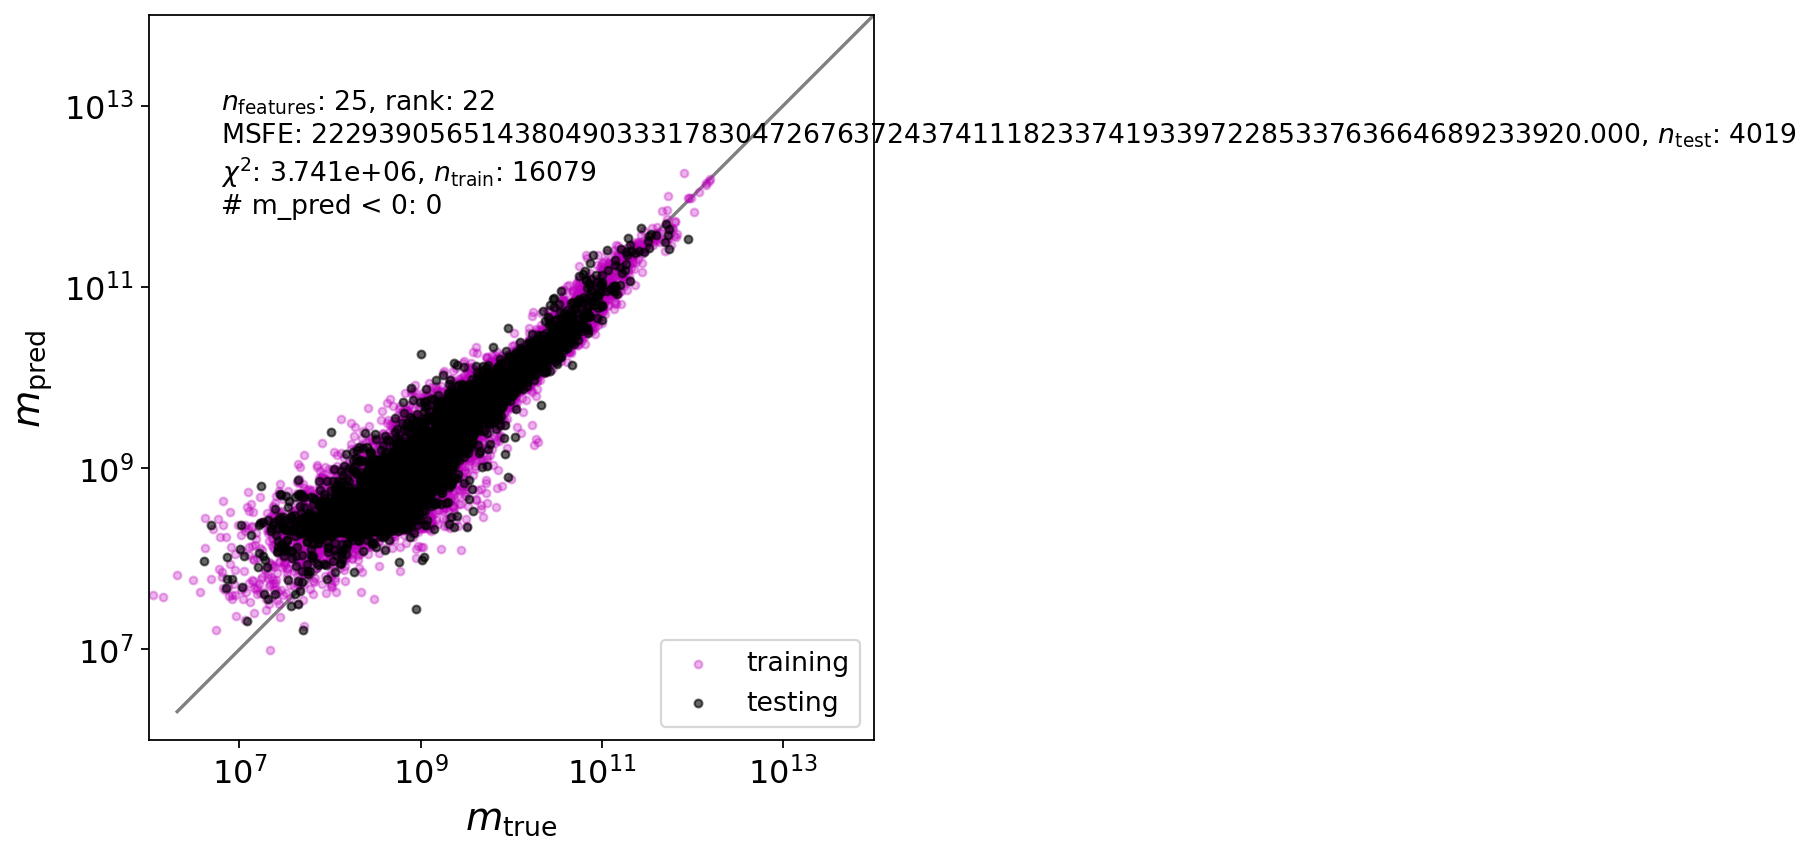

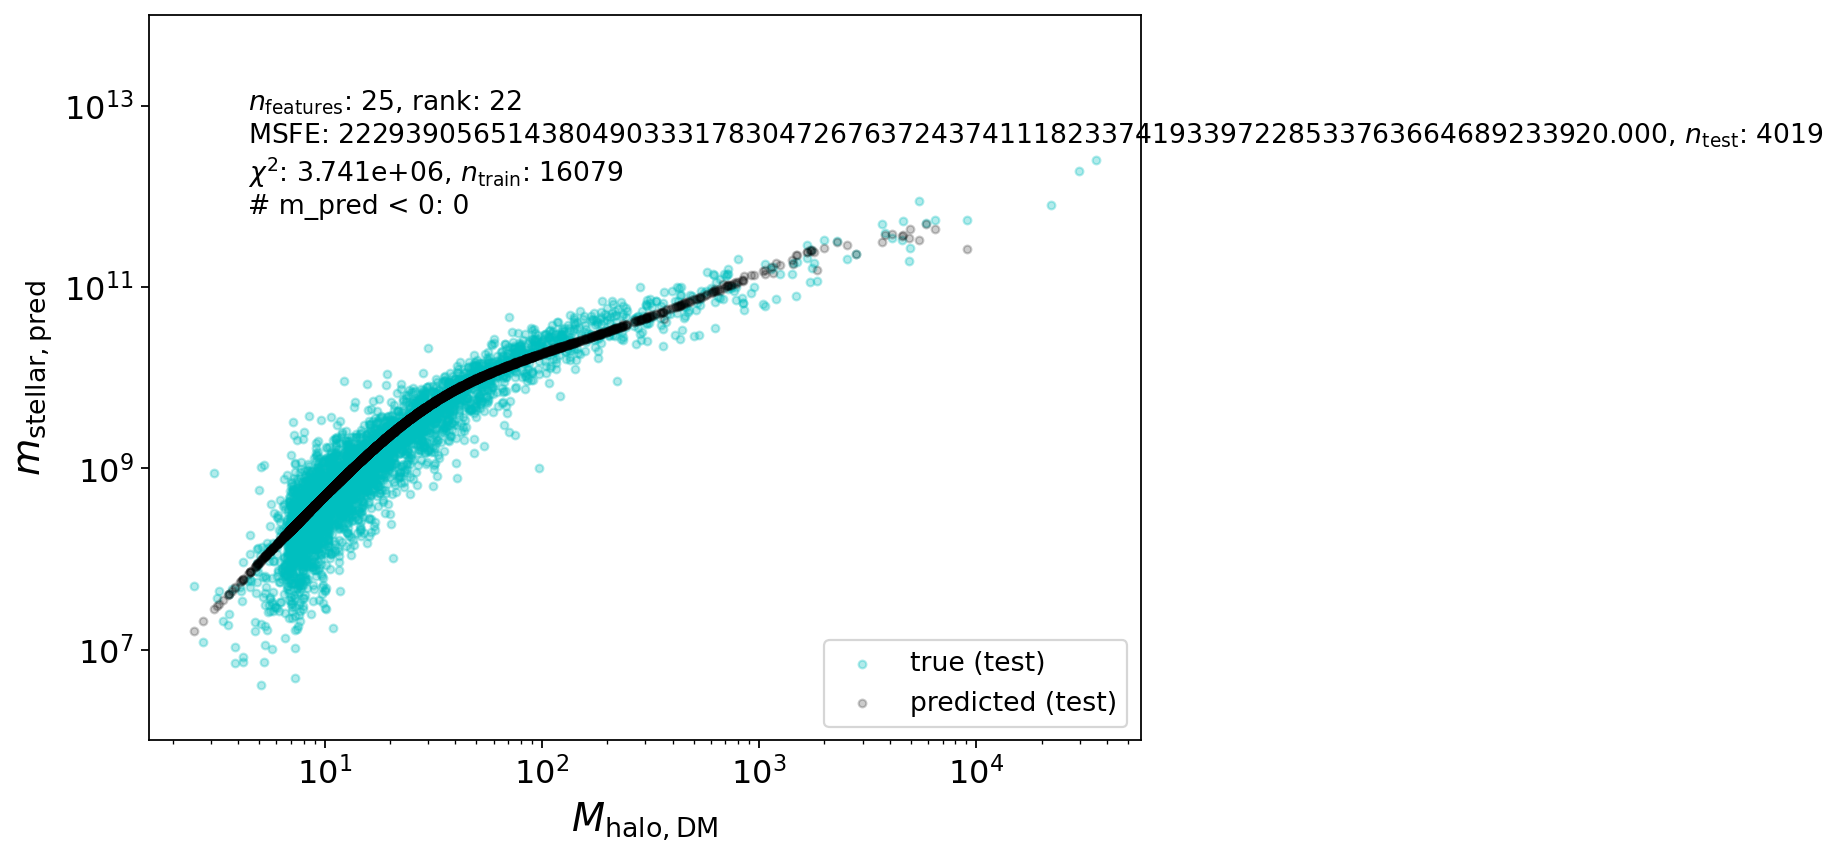

In [21]:
fitter = Fitter(scalar_featurizer_1bin.scalar_features, m_stellar, 
                y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019)
fit_and_plot(fitter, m_200m, log_y=True, y_lim=(10**6, 10**14))

2 bins, no rescaling:

scale fit
2.189814286364708
pred test
106279.77687278518
pred train
2.189814286364708


../code/fit.py:49: RuntimeWarning: overflow encountered in power
  y = 10**y
/ext3/miniconda3/lib/python3.8/site-packages/numpy/core/function_base.py:144: RuntimeWarning: invalid value encountered in multiply
  y *= step


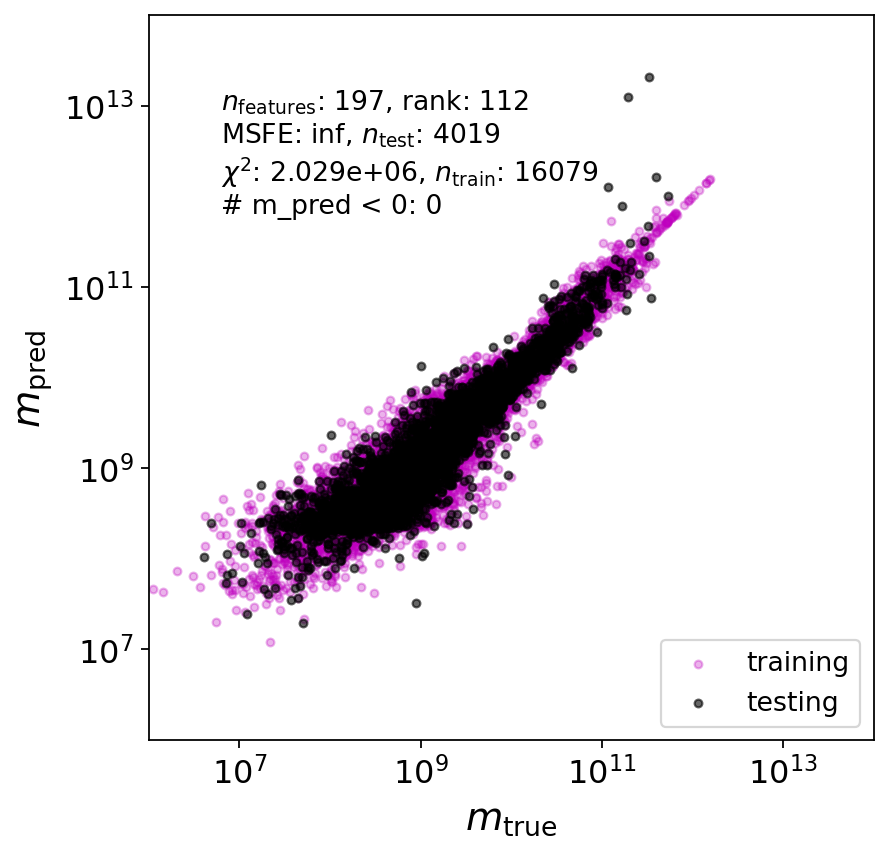

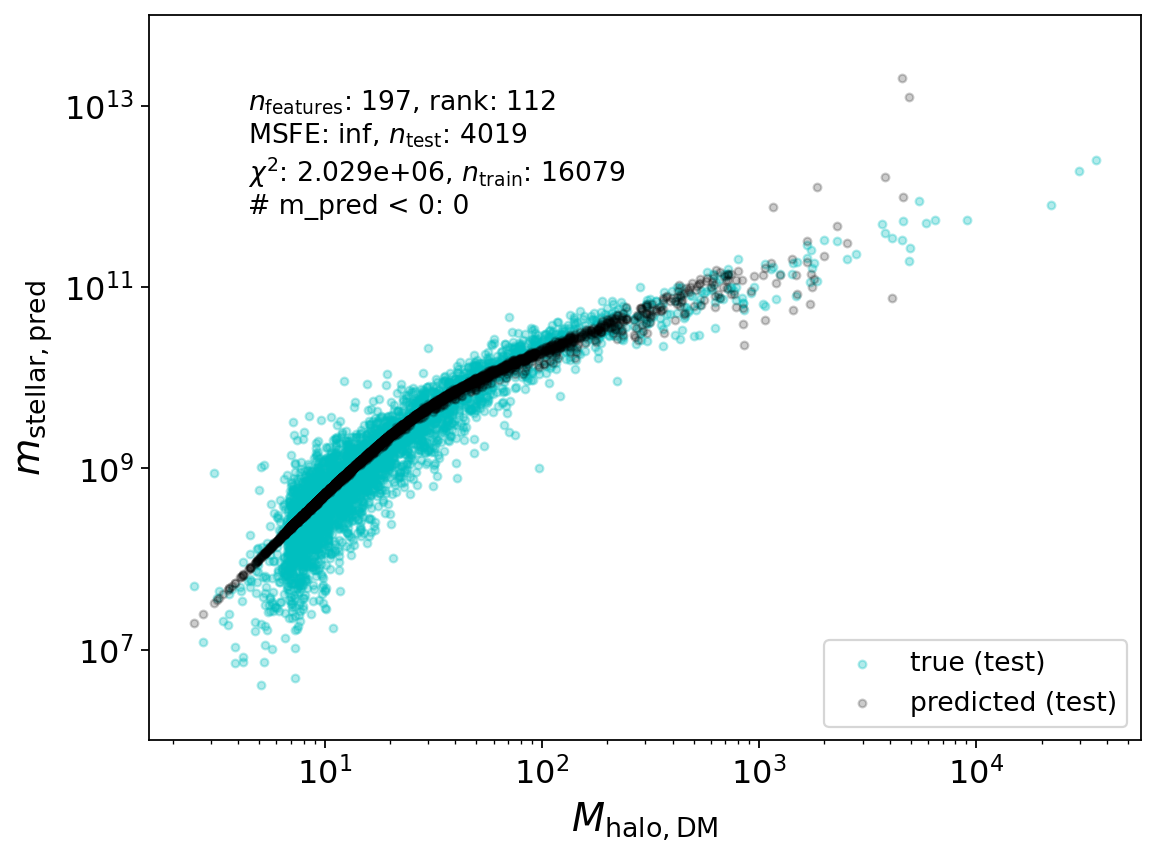

In [22]:
fitter = Fitter(scalar_featurizer_2bins.scalar_features, m_stellar, 
                y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019)
fit_and_plot(fitter, m_200m, log_y=True, y_lim=(10**6, 10**14))

2 bins, with rescaling:

scale fit
2.3657373111634556
pred test
21.3388766212301
pred train
2.3657373111634556


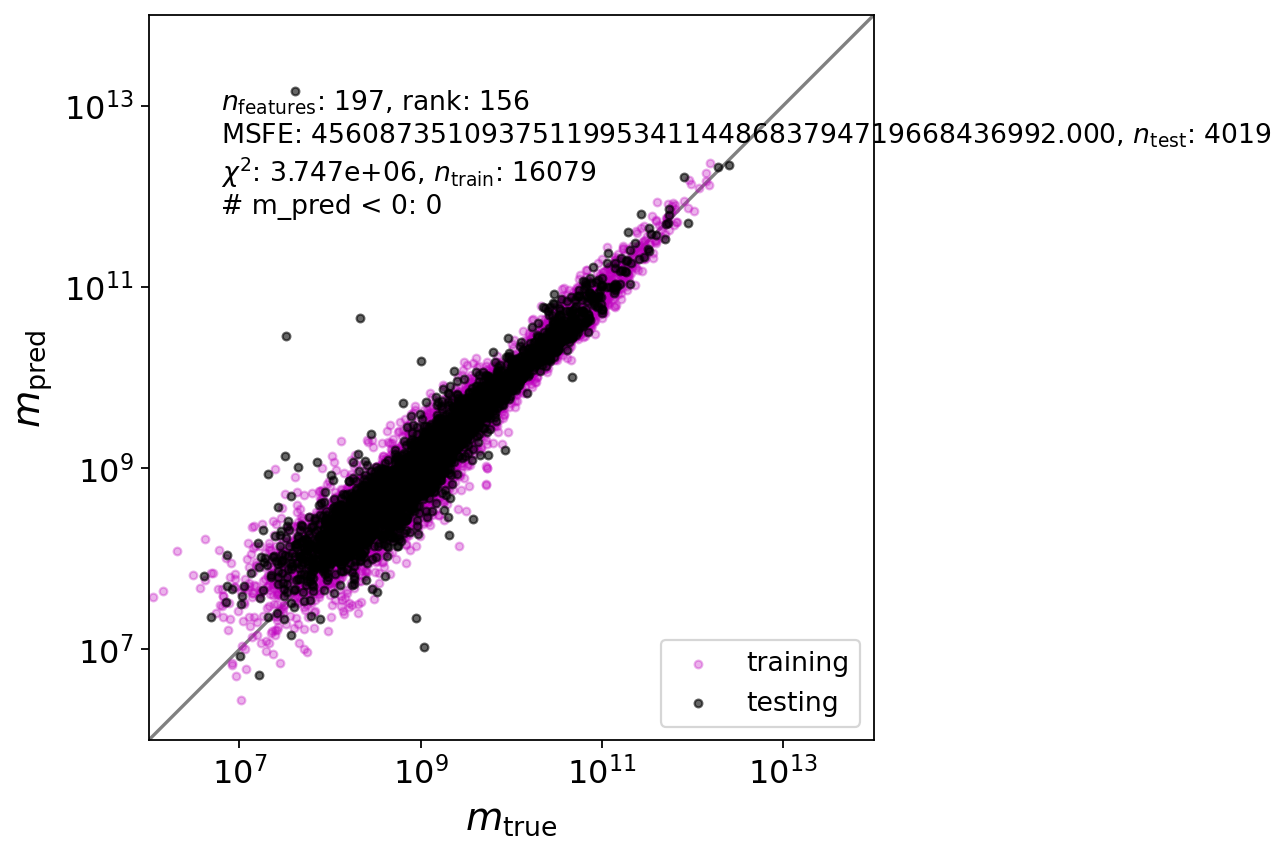

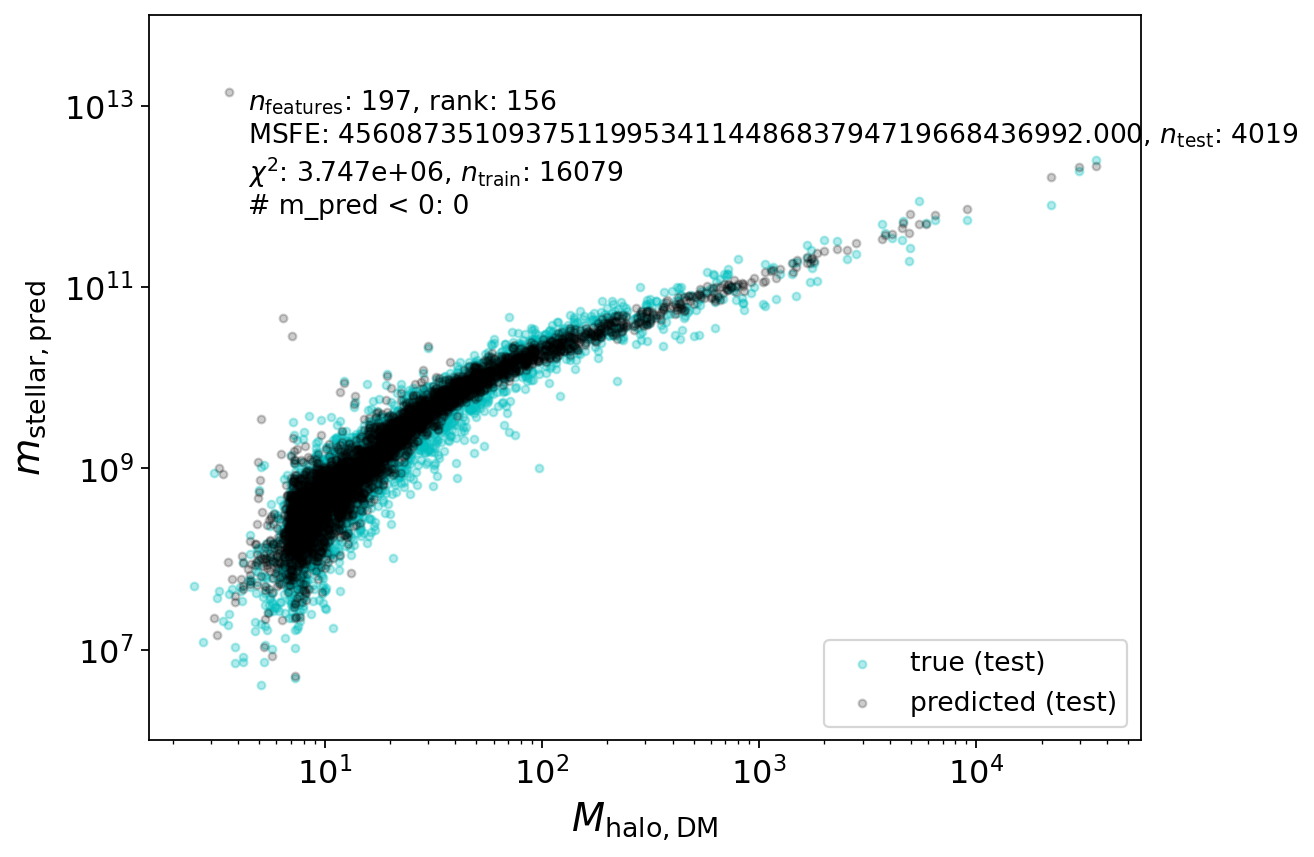

In [23]:
fitter = Fitter(scalar_featurizer_rescaled.scalar_features, m_stellar, 
                y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019)
fit_and_plot(fitter, m_200m, log_y=True, y_lim=(10**6, 10**14))